# I. Data Import

In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

In [48]:
pd.set_option('display.max_columns', None)

In [49]:
url = "https://drive.google.com/uc?id=12IOsroRdMjTEtaUdzHqgutel2cKa7aEl"
df = pd.read_csv(url)

In [50]:
df.head()

,campaign_id,platform,influencer_category,campaign_type,start_date,engagements,estimated_reach,product_sales,campaign_duration_days,end_date
0,CAMP100000,TikTok,Fitness,Giveaway,2022-01-01 00:00:00,79900,1892,2834,14,2022-01-15 00:00:00
1,CAMP100001,YouTube,Food,Product Launch,2022-01-02 00:00:00,47985,437228,165,13,2022-01-15 00:00:00
2,CAMP100002,TikTok,Travel,Brand Awareness,2022-01-03 00:00:00,13875,982513,2539,5,2022-01-08 00:00:00
3,CAMP100003,YouTube,Food,Brand Awareness,2022-01-04 00:00:00,41200,213400,100,20,2022-01-24 00:00:00
4,CAMP100004,Instagram,Food,Giveaway,2022-01-05 00:00:00,96998,42501,550,28,2022-02-02 00:00:00


# II. Data Cleaning & Feature Engineering

## Data Type

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   campaign_id             150000 non-null  object
 1   platform                150000 non-null  object
 2   influencer_category     150000 non-null  object
 3   campaign_type           150000 non-null  object
 4   start_date              150000 non-null  object
 5   engagements             150000 non-null  int64 
 6   estimated_reach         150000 non-null  int64 
 7   product_sales           150000 non-null  int64 
 8   campaign_duration_days  150000 non-null  int64 
 9   end_date                150000 non-null  object
dtypes: int64(4), object(6)
memory usage: 11.4+ MB


In [52]:
df[-1:]

,campaign_id,platform,influencer_category,campaign_type,start_date,engagements,estimated_reach,product_sales,campaign_duration_days,end_date
149999,CAMP249999,TikTok,Food,Seasonal Sale,2432-09-07 00:00:00,11233,285487,1176,21,2432-09-28 00:00:00


In [53]:
categorical_cols = ['platform', 'influencer_category', 'campaign_type']
df[categorical_cols] = df[categorical_cols].astype('category')

In [54]:
# df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
# df['end_date'] = pd.to_datetime(df['end_date'], errors='coerce')

invalid_dates = df[df['start_date'].isna() | df['end_date'].isna()]
print(invalid_dates[['campaign_id', 'start_date', 'end_date']])

Empty DataFrame
Columns: [campaign_id, start_date, end_date]
Index: []


**Important Note**: The dataset contains a substantial share of “future” campaign dates. Per the author, this is because some records were pulled from aggregator platforms that list both active and scheduled collaborations, so the dates may reflect upcoming campaigns which were not fabricated. That said, some anomalies could also stem from scraping noise or parsing errors. In our copy, problematic records account for over 41.5% of all rows, making wholesale removal impractical (it would cause severe sample loss and bias). For this project, I retained these records to prioritize building and validating the automated reporting framework; the dataset is used as a proof-of-concept reference. For production use, I would recommend retraining on proprietary enterprise data and enforcing stricter validations (e.g., date-bound filters, cross-source checks, and anomaly flags) to ensure accuracy and reliability.


In [55]:
df[-1:]

,campaign_id,platform,influencer_category,campaign_type,start_date,engagements,estimated_reach,product_sales,campaign_duration_days,end_date
149999,CAMP249999,TikTok,Food,Seasonal Sale,2432-09-07 00:00:00,11233,285487,1176,21,2432-09-28 00:00:00


## Missing Value

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   campaign_id             150000 non-null  object  
 1   platform                150000 non-null  category
 2   influencer_category     150000 non-null  category
 3   campaign_type           150000 non-null  category
 4   start_date              150000 non-null  object  
 5   engagements             150000 non-null  int64   
 6   estimated_reach         150000 non-null  int64   
 7   product_sales           150000 non-null  int64   
 8   campaign_duration_days  150000 non-null  int64   
 9   end_date                150000 non-null  object  
dtypes: category(3), int64(4), object(3)
memory usage: 8.4+ MB


In [57]:
df.columns

Index(['campaign_id', 'platform', 'influencer_category', 'campaign_type',
       'start_date', 'engagements', 'estimated_reach', 'product_sales',
       'campaign_duration_days', 'end_date'],
      dtype='object')

## Outliers Check

In [58]:
df.describe()

,engagements,estimated_reach,product_sales,campaign_duration_days
count,150000.000000,150000.000000,150000.000000,150000.000000
mean,50065.296107,500239.634920,2497.730433,14.976127
std,28847.302798,288003.388219,1443.222587,8.358356
min,100.000000,1002.000000,0.000000,1.000000
25%,25060.500000,251439.500000,1248.000000,8.000000
50%,50100.500000,500073.500000,2501.000000,15.000000
75%,75045.250000,750016.750000,3746.000000,22.000000
max,99999.000000,999992.000000,4999.000000,29.000000


In [59]:
df_viral = df[df['estimated_reach']<df['engagements']]
df['viral_flag'] = df['campaign_id'].isin(df_viral['campaign_id'])
df['viral_flag'] = df['viral_flag'].astype('category')
df['viral_flag'].value_counts()

,count
viral_flag,
False,142609
True,7391


In [60]:
df['platform'].value_counts()

,count
platform,
Instagram,59819
YouTube,45139
TikTok,29984
Twitter,15058


In [61]:
df['influencer_category'].value_counts()

,count
influencer_category,
Food,21659
Tech,21545
Fashion,21502
Gaming,21399
Travel,21344
Beauty,21340
Fitness,21211


In [62]:
df['campaign_type'].value_counts()

,count
campaign_type,
Seasonal Sale,30215
Product Launch,30009
Brand Awareness,29991
Giveaway,29952
Event Promotion,29833


## Feature Engineering

**Important Note**: Although the original dataset did not contain campaign cost information, cost was estimated using publicly available influencer rate benchmarks (e.g., CPM-based heuristics by platform). This allows the ROI calculation to more accurately reflect business reality and distinguish high-return campaigns from merely high-engagement ones.

| **Influencer Category**  | **Avg. Sponsored Post Fee** (all sizes) |
| ------------------------ | --------------------------------------- |
| **Beauty** (Cosmetics)   | \~\$1,425                               |
| **Fashion** (Apparel)    | \~\$1,393                               |
| **Gaming** (Video Games) | \~\$1,090                               |
| **Food** (Cooking/F\&B)  | \~\$1,007                               |
| **Fitness/Health**       | \~\$819                                 |
| **Travel**               | \~\$722                                 |
| **Tech** (Gadgets)       | \~\$448                                 |


| **Platform**  | **Content Type**        | **Average Base Rate (Per Post/Video)** | **Source(s)**                                                                                         |
| ------------- | ----------------------- | -------------------------------------- | ----------------------------------------------------------------------------------------------------- |
| **Instagram** | Feed Post or Reel       | ~\$850                      | [Influencer Marketing Hub](https://influencermarketinghub.com), \[Statista], \[Collabstr 2024 Report] |
| **TikTok**    | Short-form Video (≤60s) | ~\$1,100                      | [Collabstr](https://collabstr.com/creator-pricing), \[Afluencer], \[Shopify Influencer Guide]         |
| **YouTube**   | Long-form Video (≥5min) | ~\$3,000                    | \[Influencer Marketing Hub], \[Sortlist], \[IZEA], \[Statista]                                        |
| **Twitter/X** | Sponsored Tweet         | ~\$550                        | \[Sortlist], \[Afluencer], \[IZEA], \[Collabstr]                                                      |


These are cross-tier averages (i.e. mixing nano, micro, macro, and mega influencers). Actual pricing will vary depending on follower count, engagement, deliverables, and campaign type.

The rates refer to single content deliverables (e.g. one Instagram post or TikTok video), excluding additional fees such as content usage rights, exclusivity, or multi-post bundles.

In [63]:
# influencer category
category_cost = {
    'Beauty': 1425,
    'Fashion': 1393,
    'Gaming': 1090,
    'Food': 1007,
    'Fitness': 819,
    'Travel': 722,
    'Tech': 448
}

# Platform
platform_cost = {
    'Instagram': 850,
    'TikTok': 1100,
    'YouTube': 3000,
    'Twitter': 550
}

def calculate_estimated_cost(row):
    cost1 = category_cost.get(row['influencer_category'], 0)
    platform_name = row['platform']
    cost2 = platform_cost.get(platform_name, 0)
    return cost1 + cost2

df['estimated_cost'] = df.apply(calculate_estimated_cost, axis=1)


In [64]:
df.head()

,campaign_id,platform,influencer_category,campaign_type,start_date,engagements,estimated_reach,product_sales,campaign_duration_days,end_date,viral_flag,estimated_cost
0,CAMP100000,TikTok,Fitness,Giveaway,2022-01-01 00:00:00,79900,1892,2834,14,2022-01-15 00:00:00,True,1919
1,CAMP100001,YouTube,Food,Product Launch,2022-01-02 00:00:00,47985,437228,165,13,2022-01-15 00:00:00,False,4007
2,CAMP100002,TikTok,Travel,Brand Awareness,2022-01-03 00:00:00,13875,982513,2539,5,2022-01-08 00:00:00,False,1822
3,CAMP100003,YouTube,Food,Brand Awareness,2022-01-04 00:00:00,41200,213400,100,20,2022-01-24 00:00:00,False,4007
4,CAMP100004,Instagram,Food,Giveaway,2022-01-05 00:00:00,96998,42501,550,28,2022-02-02 00:00:00,True,1857


In [65]:
df['ROI'] = df['product_sales'] / df['estimated_cost']

def safe_divide(numerator, denominator):
    return np.where(denominator > 0, numerator / denominator, 0)

df['Conversion_rate'] = safe_divide(df['product_sales'], df['estimated_reach'])
df['Engagement_rate'] = safe_divide(df['engagements'], df['estimated_reach'])
df['Cost_per_reach'] = safe_divide(df['estimated_cost'], df['estimated_reach'])
df.head()

,campaign_id,platform,influencer_category,campaign_type,start_date,engagements,estimated_reach,product_sales,campaign_duration_days,end_date,viral_flag,estimated_cost,ROI,Conversion_rate,Engagement_rate,Cost_per_reach
0,CAMP100000,TikTok,Fitness,Giveaway,2022-01-01 00:00:00,79900,1892,2834,14,2022-01-15 00:00:00,True,1919,1.476811,1.497886,42.230444,1.014271
1,CAMP100001,YouTube,Food,Product Launch,2022-01-02 00:00:00,47985,437228,165,13,2022-01-15 00:00:00,False,4007,0.041178,0.000377,0.109748,0.009165
2,CAMP100002,TikTok,Travel,Brand Awareness,2022-01-03 00:00:00,13875,982513,2539,5,2022-01-08 00:00:00,False,1822,1.393524,0.002584,0.014122,0.001854
3,CAMP100003,YouTube,Food,Brand Awareness,2022-01-04 00:00:00,41200,213400,100,20,2022-01-24 00:00:00,False,4007,0.024956,0.000469,0.193065,0.018777
4,CAMP100004,Instagram,Food,Giveaway,2022-01-05 00:00:00,96998,42501,550,28,2022-02-02 00:00:00,True,1857,0.296177,0.012941,2.282252,0.043693


In [66]:
df['ROI_flag'] = (df['ROI'] >= 1).astype(int)
df['ROI_flag'].value_counts()

,count
ROI_flag,
0,75273
1,74727


# III. EDA

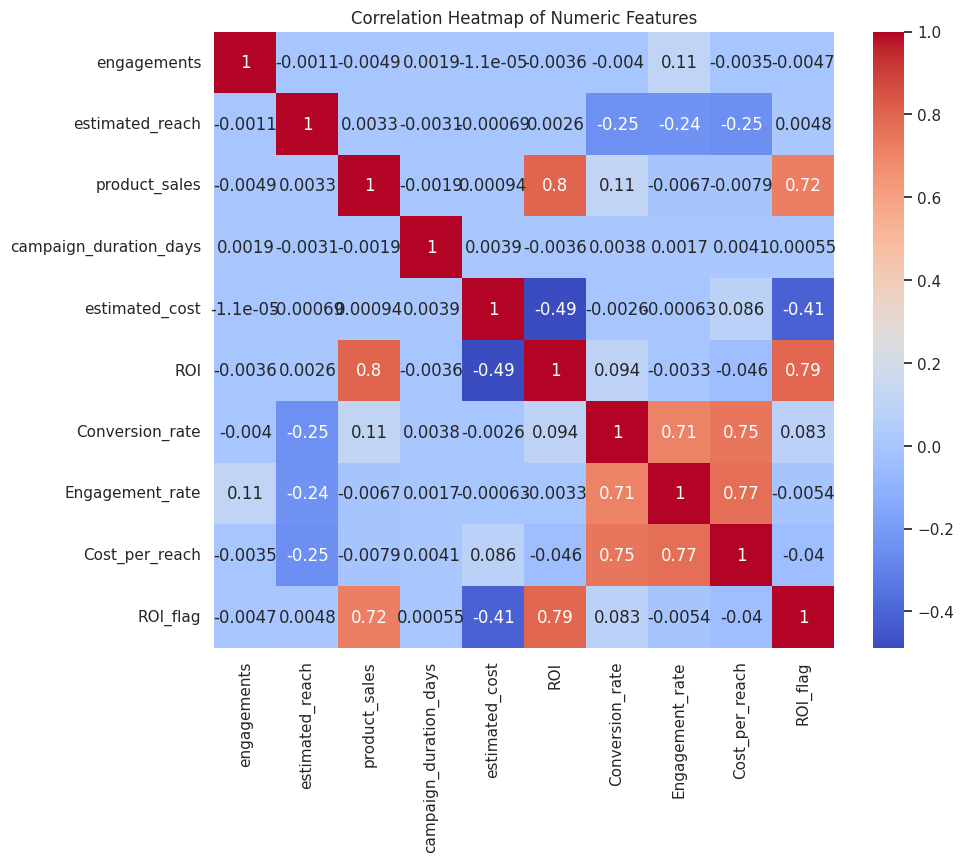

In [67]:
numeric_df = df.select_dtypes(include='number')

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

## ROI Benchmark

/tmp/ipython-input-1478621559.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='platform', y='ROI', estimator='mean', ci=None)


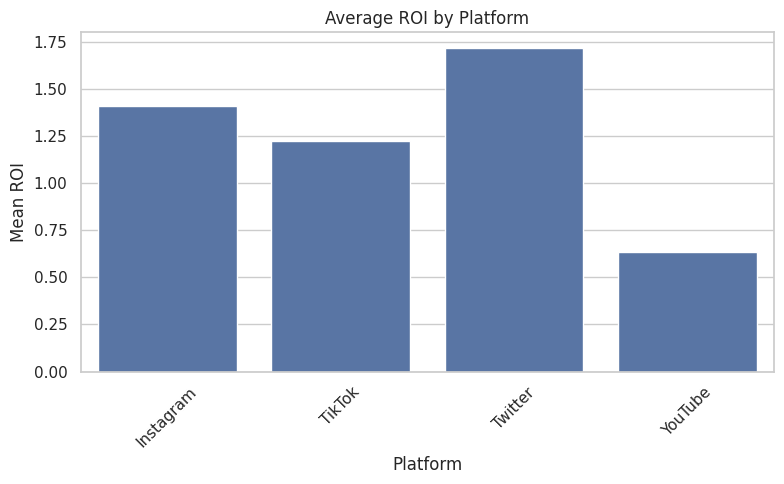

/tmp/ipython-input-1478621559.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='influencer_category', y='ROI', estimator='mean', ci=None)


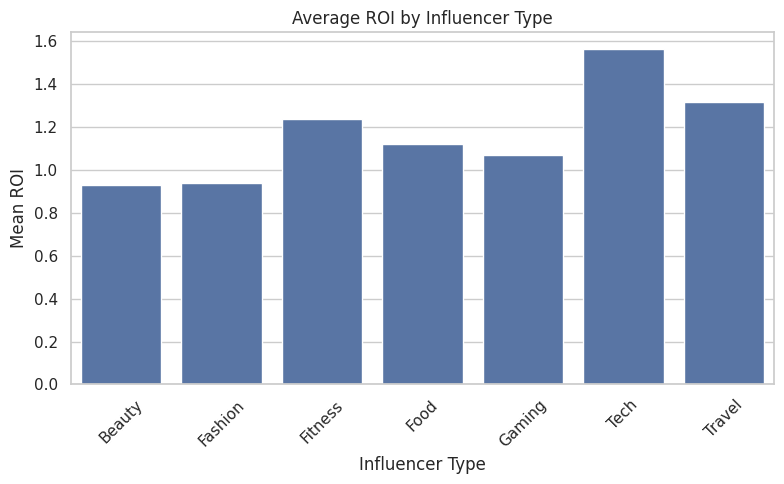

/tmp/ipython-input-1478621559.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='campaign_type', y='ROI', estimator='mean', ci=None)


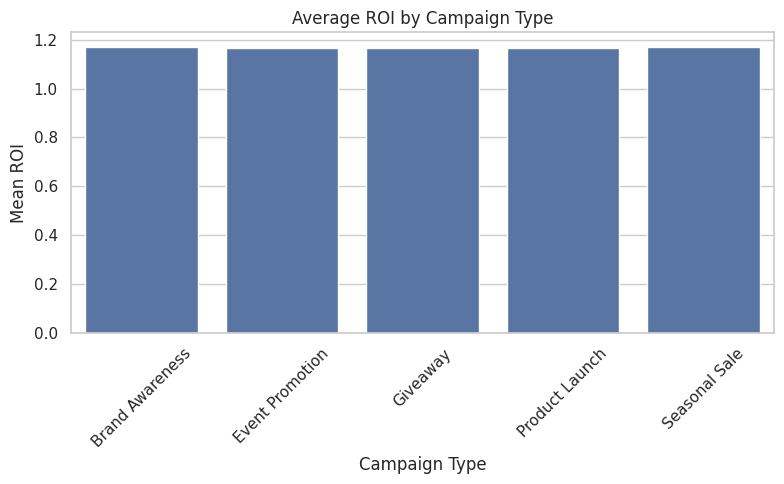

In [68]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='platform', y='ROI', estimator='mean', ci=None)
plt.title('Average ROI by Platform')
plt.ylabel('Mean ROI')
plt.xlabel('Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='influencer_category', y='ROI', estimator='mean', ci=None)
plt.title('Average ROI by Influencer Type')
plt.ylabel('Mean ROI')
plt.xlabel('Influencer Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='campaign_type', y='ROI', estimator='mean', ci=None)
plt.title('Average ROI by Campaign Type')
plt.ylabel('Mean ROI')
plt.xlabel('Campaign Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Conversion Rate

/tmp/ipython-input-3991067726.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='platform', y='Conversion_rate', estimator='mean', ci=None)


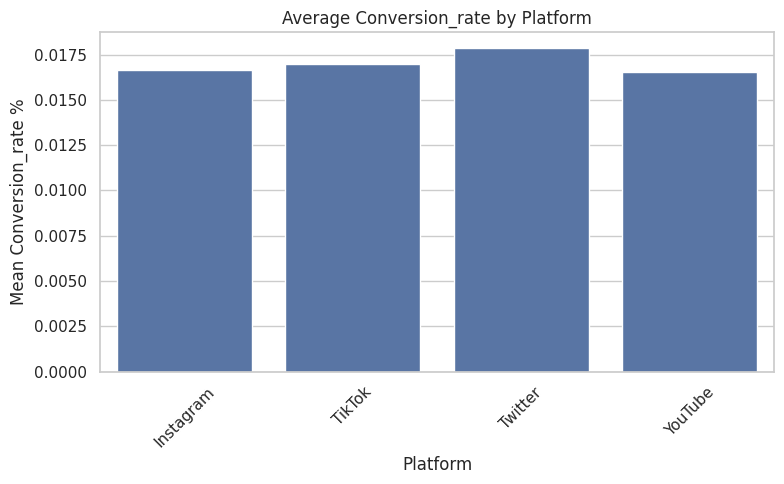

/tmp/ipython-input-3991067726.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='influencer_category', y='Conversion_rate', estimator='mean', ci=None)


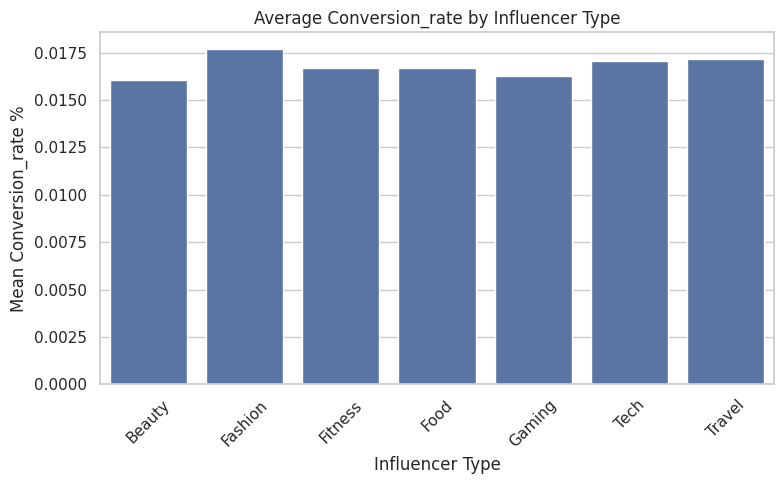

/tmp/ipython-input-3991067726.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='campaign_type', y='Conversion_rate', estimator='mean', ci=None)


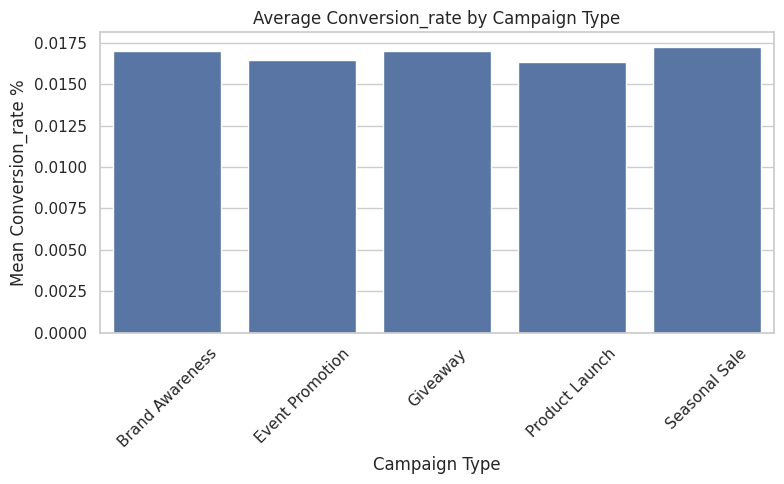

In [69]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='platform', y='Conversion_rate', estimator='mean', ci=None)
plt.title('Average Conversion_rate by Platform')
plt.ylabel('Mean Conversion_rate %')
plt.xlabel('Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='influencer_category', y='Conversion_rate', estimator='mean', ci=None)
plt.title('Average Conversion_rate by Influencer Type')
plt.ylabel('Mean Conversion_rate %')
plt.xlabel('Influencer Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='campaign_type', y='Conversion_rate', estimator='mean', ci=None)
plt.title('Average Conversion_rate by Campaign Type')
plt.ylabel('Mean Conversion_rate %')
plt.xlabel('Campaign Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Engagement Rate

/tmp/ipython-input-796380882.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='platform', y='Engagement_rate', estimator='mean', ci=None)


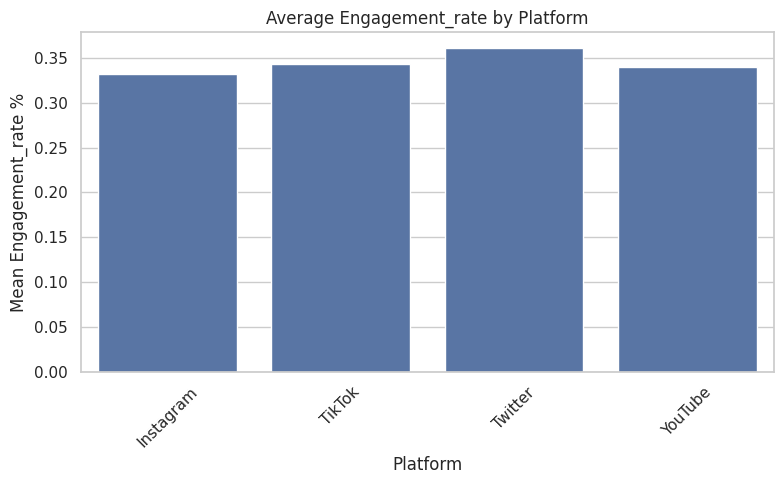

/tmp/ipython-input-796380882.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='influencer_category', y='Engagement_rate', estimator='mean', ci=None)


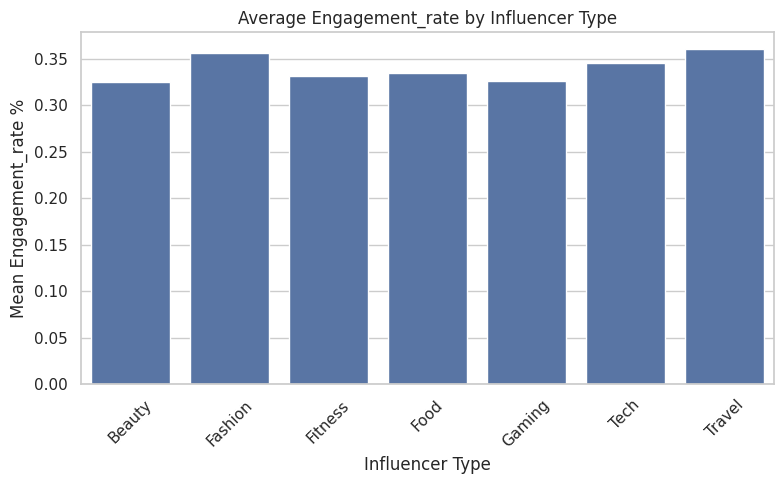

/tmp/ipython-input-796380882.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x='campaign_type', y='Engagement_rate', estimator='mean', ci=None)


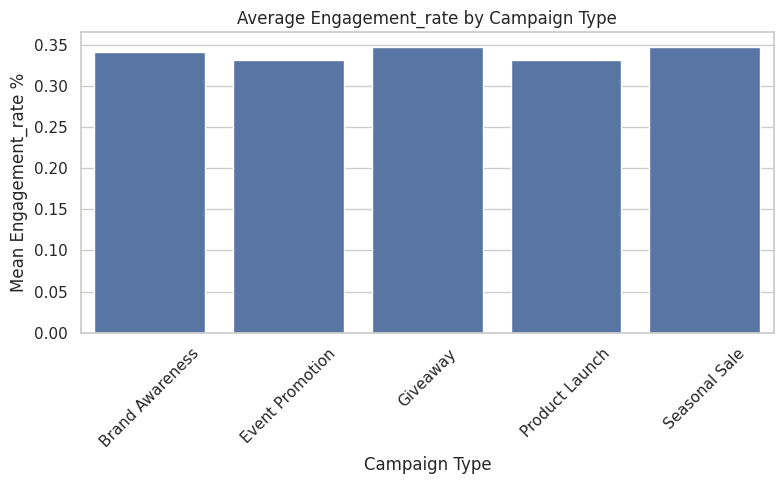

In [70]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='platform', y='Engagement_rate', estimator='mean', ci=None)
plt.title('Average Engagement_rate by Platform')
plt.ylabel('Mean Engagement_rate %')
plt.xlabel('Platform')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='influencer_category', y='Engagement_rate', estimator='mean', ci=None)
plt.title('Average Engagement_rate by Influencer Type')
plt.ylabel('Mean Engagement_rate %')
plt.xlabel('Influencer Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df, x='campaign_type', y='Engagement_rate', estimator='mean', ci=None)
plt.title('Average Engagement_rate by Campaign Type')
plt.ylabel('Mean Engagement_rate %')
plt.xlabel('Campaign Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# IV. Modeling

In [71]:
X = df[['platform', 'influencer_category', 'campaign_type',
        'estimated_reach', 'campaign_duration_days', 'estimated_cost']]
y = df['ROI_flag']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=25
)
categorical_features = ['platform', 'influencer_category', 'campaign_type']
numeric_features = ['estimated_reach', 'campaign_duration_days', 'estimated_cost']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=300,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features='log2',
        max_depth=5,
        class_weight='balanced',
        random_state=25
    ))
])


In [73]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Low ROI", "High ROI"]))

              precision    recall  f1-score   support

     Low ROI       0.79      0.48      0.60     15068
    High ROI       0.62      0.87      0.73     14932

    accuracy                           0.68     30000
   macro avg       0.71      0.68      0.66     30000
weighted avg       0.71      0.68      0.66     30000



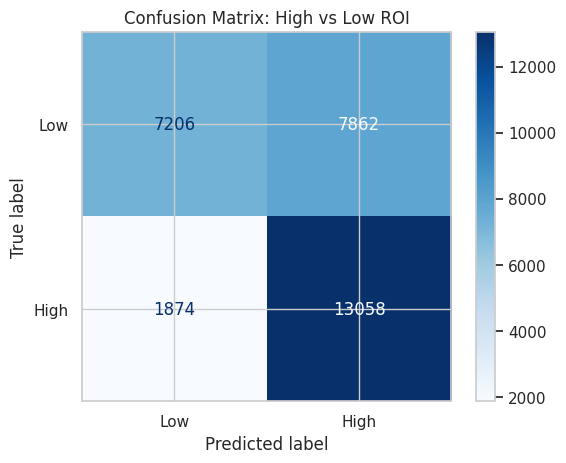

In [74]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "High"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: High vs Low ROI")
plt.show()

results = pd.DataFrame({
    'Actual (High ROI)': y_test,
    'Predicted (High ROI)': y_pred
}).reset_index(drop=True)

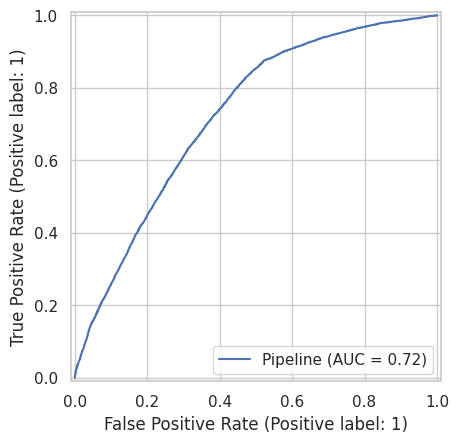

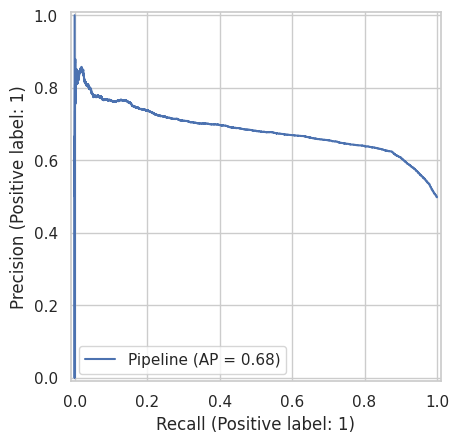

In [75]:
RocCurveDisplay.from_estimator(pipeline, X_test, y_test);
PrecisionRecallDisplay.from_estimator(pipeline, X_test, y_test);

# V. Model Interpretability

## High-ROI Probability Patterns

In [76]:
X_test_copy = X_test.copy()
X_test_copy['high_ROI_pred'] = y_pred
X_test_copy['prob_high_ROI'] = pipeline.predict_proba(X_test)[:, 1]

/tmp/ipython-input-381174901.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = X_test_copy.pivot_table(index='platform', columns='campaign_type', values='prob_high_ROI', aggfunc='mean')


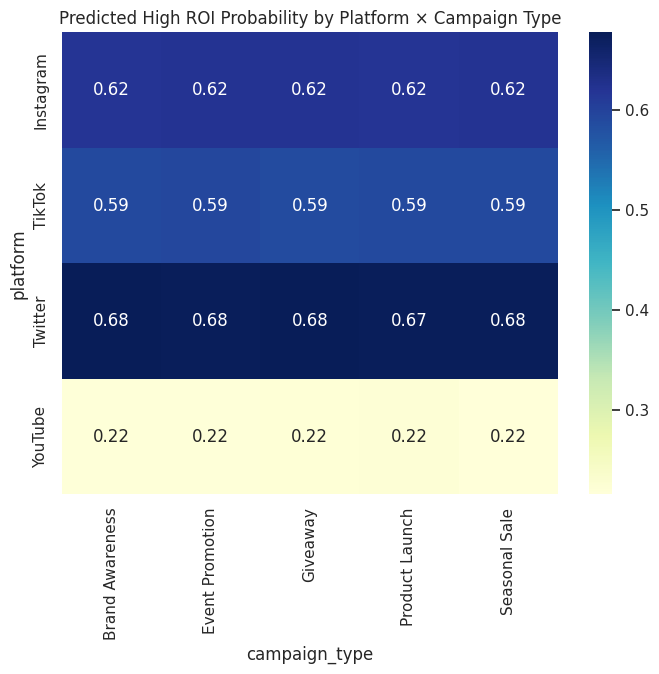

In [77]:
# Platform X Campaign Type
pivot = X_test_copy.pivot_table(index='platform', columns='campaign_type', values='prob_high_ROI', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Predicted High ROI Probability by Platform × Campaign Type")
plt.show()

/tmp/ipython-input-2334812703.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = X_test_copy.pivot_table(index='platform', columns='influencer_category', values='prob_high_ROI', aggfunc='mean')


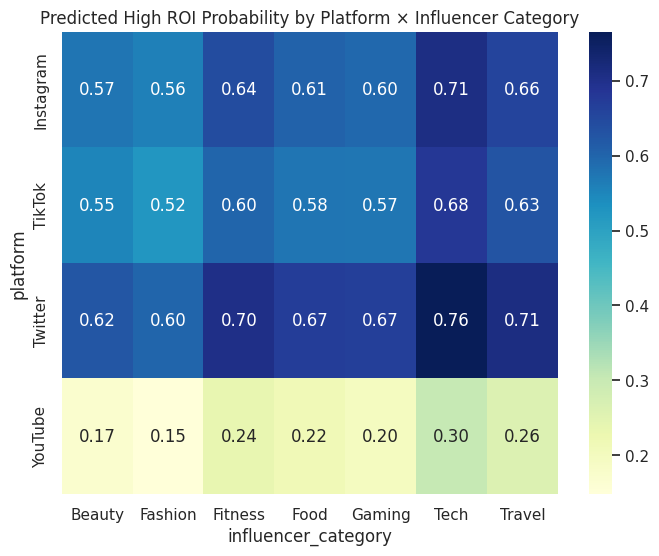

In [78]:
# Platform X Influencer Type
pivot = X_test_copy.pivot_table(index='platform', columns='influencer_category', values='prob_high_ROI', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Predicted High ROI Probability by Platform × Influencer Category")
plt.show()

/tmp/ipython-input-3059492745.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = X_test_copy.pivot_table(index='campaign_type', columns='influencer_category', values='prob_high_ROI', aggfunc='mean')


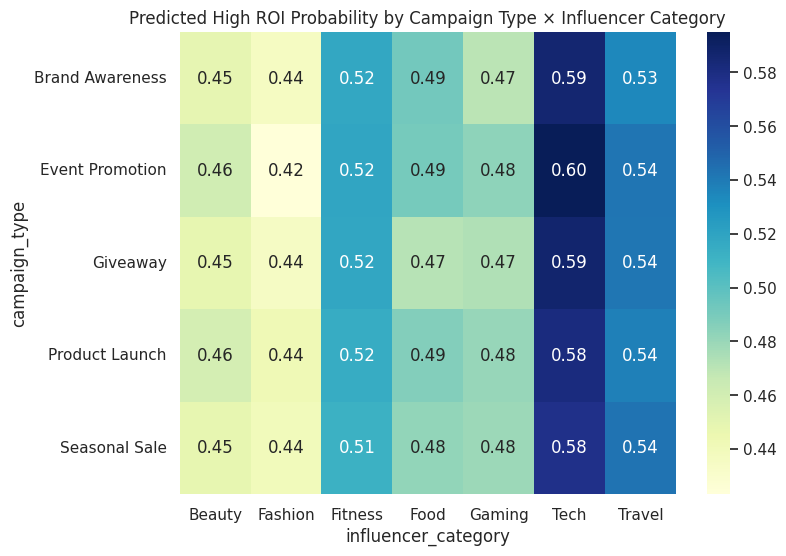

In [79]:
# Campaign Type X Influencer Type
pivot = X_test_copy.pivot_table(index='campaign_type', columns='influencer_category', values='prob_high_ROI', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Predicted High ROI Probability by Campaign Type × Influencer Category")
plt.show()

##Partial Dependence Plot（PDP）
Partial dependence plots highlight the non-linear influence of numeric features

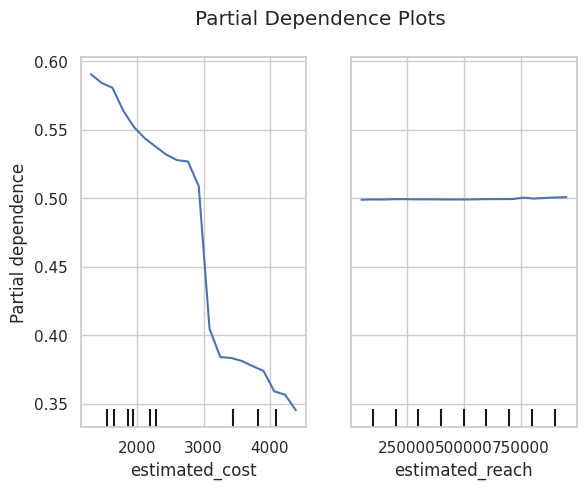

In [80]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    pipeline,
    X,
    features=['estimated_cost', 'estimated_reach'],
    kind="average",
    grid_resolution=20
)
plt.suptitle("Partial Dependence Plots")
plt.show()


# VI. Automation & Reporting

## Preparation

In [81]:
import pickle

with open("roi_model.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [82]:
df.to_csv("cleaned_campaign_data.csv", index=False)

In [83]:
!pip install streamlit pyngrok --quiet

In [84]:
!ngrok config add-authtoken 30yYfzONvZeAjTNbuqZLoTB8jpn_6aoem1fKj2hkvDAjfc2Up

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


## Streamlit

In [85]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from datetime import date
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metric_all_dimensions(df, influencer_category, platform, campaign_type, user_value, metric_name):
    dims = {
        "Influencer Category": ("influencer_category", influencer_category),
        "Platform": ("platform", platform),
        "Campaign Type": ("campaign_type", campaign_type)
    }

    data = []
    for label, (col_name, selected_val) in dims.items():
        benchmark = df[df[col_name] == selected_val][metric_name].mean()
        data.append({
            "Dimension": label,
            "Type": "Benchmark",
            metric_name: benchmark
        })
        data.append({
            "Dimension": label,
            "Type": "Your Input",
            metric_name: user_value
        })

    plot_df = pd.DataFrame(data)

    plt.figure(figsize=(7, 5))
    sns.barplot(data=plot_df, x="Dimension", y=metric_name, hue="Type", palette=["gray", "red"])
    plt.title(f"{metric_name.replace('_', ' ').title()}: Your Input vs Benchmark")
    plt.ylabel(metric_name.replace('_', ' ').title())
    max_y = plot_df[metric_name].max()
    plt.ylim(0, max_y * 1.2 if max_y > 0 else 1.5)
    plt.tight_layout()
    st.pyplot(plt.gcf())

with open("roi_model.pkl", "rb") as f:
    model = pickle.load(f)

df = pd.read_csv("cleaned_campaign_data.csv")

def predict_proba(input_df):
    return model.predict_proba(input_df)[:, 1][0]

def predict_class(input_df):
    return model.predict(input_df)[0]

st.set_page_config(page_title="Campaign ROI Report Generator", layout="centered")
st.title("📈 Campaign ROI Report Generator")
st.markdown("Select mode and enter campaign details to generate a predictive or post-launch performance report.")

# User Choice of Mode
mode = st.radio("Select Report Mode", ["Pre-Campaign Prediction", "Post-Campaign Evaluation"])

# User Input
st.header("📋 Campaign Configuration")
platform = st.selectbox("Platform", ['Instagram', 'TikTok', 'YouTube', 'Twitter'])
category = st.selectbox("Influencer Category", ['Food', 'Travel', 'Beauty', 'Tech', 'Fashion', 'Fitness', 'Gaming'])
campaign_type = st.selectbox("Campaign Type", ['Product Launch', 'Seasonal Sale', 'Event Promotion', 'Giveaway', 'Brand Awareness'])
estimated_reach = st.number_input("Estimated Reach", min_value=1000, step=1000, value=50000)
estimated_cost = st.number_input("Estimated Cost (USD)", min_value=100.0, step=100.0, value=1000.0)
duration = st.slider("Campaign Duration (days)", min_value=1, max_value=60, value=14)

# Input DataFrame
input_base = {
    'platform': platform,
    'influencer_category': category,
    'campaign_type': campaign_type,
    'estimated_reach': estimated_reach,
    'estimated_cost': estimated_cost,
    'campaign_duration_days': duration
}

# Mode 1: Pre-Campaign Prediction
if mode == "Pre-Campaign Prediction":
    st.subheader("🎯 Predicted ROI Evaluation")
    input_df = pd.DataFrame([input_base])

    roi_proba = predict_proba(input_df)
    predicted_class = predict_class(input_df)
    predicted_label = "🟢 High ROI" if predicted_class == 1 else "🔴 Low ROI"

    st.markdown(f"**Prediction:** {predicted_label}")
    st.markdown(f"**Confidence:** {roi_proba:.1%}")

    st.subheader("🧠 Suggested Action")
    if predicted_class == 1:
        st.success("This campaign configuration is likely to yield strong ROI.")
    else:
        st.warning("This configuration may underperform. Consider adjusting platform or campaign type.")

    report_text = f"""\
Campaign Prediction Report

Platform: {platform}
Category: {category}
Type: {campaign_type}
Estimated Reach: {estimated_reach}
Estimated Cost: ${estimated_cost:,.2f}
Duration: {duration} days

Predicted ROI: {predicted_label}
Confidence Score: {roi_proba:.1%}
"""

# Mode 2: Post-Campaign Evaluation
else:
    st.header("📈 Actual Performance Inputs")
    actual_sales = st.number_input("Actual Product Sales", min_value=0, value=0)
    actual_engagements = st.number_input("Actual Engagements", min_value=0, value=0)
    start_date = st.date_input("Campaign Start Date", value=date(2025, 1, 1))
    end_date = st.date_input("Campaign End Date", value=date(2025, 1, 15))

    actual_duration = (end_date - start_date).days if (end_date - start_date).days > 0 else 1
    actual_roi = actual_sales / estimated_cost if estimated_cost > 0 else 0
    engagement_rate = actual_engagements / estimated_reach if estimated_reach > 0 else 0
    conversion_rate = actual_sales / estimated_reach if estimated_reach > 0 else 0

    st.subheader("📊 Calculated Metrics")
    st.markdown(f"- **Actual ROI:** {actual_roi:.2f}")
    st.markdown(f"- **Engagement Rate:** {engagement_rate:.2%}")
    st.markdown(f"- **Conversion Rate:** {conversion_rate:.2%}")
    st.markdown(f"- **Actual Duration:** {actual_duration} days")

    report_text = f"""\
Campaign Performance Report

Platform: {platform}
Category: {category}
Type: {campaign_type}
Duration: {actual_duration} days
Estimated Cost: ${estimated_cost:,.2f}

Product Sales: {actual_sales}
ROI: {actual_sales} / {estimated_cost} = {actual_roi:.2f}
Engagements: {actual_engagements}
Engagement Rate: {engagement_rate:.2%}
Conversion Rate: {conversion_rate:.2%}

Insights:
{"Strong ROI ✅" if actual_roi >= 1 else "Low ROI ❌ - optimize content or influencer mix"}
"""

    st.subheader("ROI vs Benchmark")
    plot_metric_all_dimensions(
        df=df,
        influencer_category=category,
        platform=platform,
        campaign_type=campaign_type,
        user_value=actual_roi,
        metric_name="ROI"
    )

    st.subheader("Conversion Rate vs Benchmark")
    plot_metric_all_dimensions(
        df=df,
        influencer_category=category,
        platform=platform,
        campaign_type=campaign_type,
        user_value=conversion_rate,
        metric_name="Conversion_rate"
    )

    st.subheader("Engagement Rate vs Benchmark")
    plot_metric_all_dimensions(
        df=df,
        influencer_category=category,
        platform=platform,
        campaign_type=campaign_type,
        user_value=engagement_rate,
        metric_name="Engagement_rate"
    )

# Report Download
st.subheader("📥 Downloadable Report")
st.download_button(
    label="Download Report as TXT",
    data=report_text,
    file_name="campaign_report.txt",
    mime="text/plain"
)

with st.expander("🔍 View Full Text Report"):
    st.code(report_text)


Overwriting app.py


In [86]:
from pyngrok import ngrok
!streamlit run app.py &> logs.txt &
public_url = ngrok.connect(8501, "http")
public_url

<NgrokTunnel: "https://3e0ace494480.ngrok-free.app" -> "http://localhost:8501">